# Предсказание победы в матче CS:GO

## 1 Загрузка и предварительный анализ данных

### 1.1 Загрузка данных

Модули.

In [1]:
# !pip install lightgbm
# !pip install catboost

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import plot_roc_curve

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

Загрузка данных.

In [3]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
players_feats = pd.read_csv('./data/players_feats.csv')

Размеры загруженных датасетов.

In [4]:
train.shape, test.shape, players_feats.shape

((713, 5), (30, 5), (1486, 128))

### 1.2 Тренировочные данные о матчах

In [5]:
display(train.head(3))
train.info()

,map_id,team1_id,team2_id,map_name,who_win
0,289,6665,7718,Ancient,0
1,715,4411,10577,Inferno,0
2,157,11251,9455,Nuke,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 713 entries, 0 to 712
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   map_id    713 non-null    int64 
 1   team1_id  713 non-null    int64 
 2   team2_id  713 non-null    int64 
 3   map_name  713 non-null    object
 4   who_win   713 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 28.0+ KB


Пропусков нет, типы данных адекватные.

Доля побед второй команды.

In [6]:
print(f'{(train.who_win == 1).sum() / len(train) :.2%}')

45.86%


Выраженного дисбаланса нет.

### 1.3 Тестовые данные о матчах

In [7]:
display(test.head(3))
test.info()

,index,map_id,team1_id,team2_id,map_name
0,713,309,5973,5752,Dust2
1,714,541,5973,5752,Vertigo
2,715,1,8297,7020,Nuke


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   index     30 non-null     int64 
 1   map_id    30 non-null     int64 
 2   team1_id  30 non-null     int64 
 3   team2_id  30 non-null     int64 
 4   map_name  30 non-null     object
dtypes: int64(4), object(1)
memory usage: 1.3+ KB


Удалим столбец **index**, он к делу не относится. В остальном все как у тренировочной таблицы.

In [8]:
test.drop(columns=['index'], inplace=True)

В обеих таблицах нет пропусков, типы данных парвильные.

### 1.4 Метрики игроков

In [9]:
display(players_feats.head(3))
players_feats.info()

,p1_id,p1_total_kills,p1_headshots,p1_total_deaths,p1_kd_ratio,p1_damage_per_round,p1_grenade_damage_per_round,p1_maps_played,p1_rounds_played,p1_kills_per_round,...,p5_kill_death_difference,p5_total_opening_kills,p5_total_opening_deaths,p5_opening_kill_ratio,p5_opening_kill_rating,p5_team_win_percent_after_first_kill,p5_first_kill_in_won_rounds,team_id,map_name,map_id
0,4954,90,42.2,112,0.80,76.3,5.9,6,156,0.58,...,5,25,12,2.08,1.28,84.0,25.0,6665,Ancient,635
1,5794,45,60.0,57,0.79,82.3,10.9,3,68,0.66,...,96,54,34,1.59,1.17,70.4,16.7,7532,Ancient,635
2,4954,156,51.9,167,0.93,63.5,3.4,10,265,0.59,...,22,26,19,1.37,1.10,88.5,20.5,6665,Dust2,583


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1486 entries, 0 to 1485
Columns: 128 entries, p1_id to map_id
dtypes: float64(80), int64(47), object(1)
memory usage: 1.5+ MB


Названия метрик на примере первого игрока всех команд.

In [10]:
print(*players_feats.columns[players_feats.columns.str.contains('1')], sep='\n')

p1_id
p1_total_kills
p1_headshots
p1_total_deaths
p1_kd_ratio
p1_damage_per_round
p1_grenade_damage_per_round
p1_maps_played
p1_rounds_played
p1_kills_per_round
p1_assists_per_round
p1_deaths_per_round
p1_saved_by_teammate_per_round
p1_saved_teammates_per_round
p1_rating
p1_kill_death
p1_kill_round
p1_rounds_with_kills
p1_kill_death_difference
p1_total_opening_kills
p1_total_opening_deaths
p1_opening_kill_ratio
p1_opening_kill_rating
p1_team_win_percent_after_first_kill
p1_first_kill_in_won_rounds


Названия столбцов, не относящихся к метрикам.

In [11]:
print(*players_feats.columns[~players_feats.columns.str.contains('|'.join(['1', '2', '3', '4', '5']))], sep='\n')

team_id
map_name
map_id


Рассмотрим описательную статистику метрик на примере первого игрока всех команд, чтобы оценить порядок и разброс.

In [12]:
players_feats.loc[:, players_feats.columns.str.contains('|'.join(['p1_']))].describe()

,p1_id,p1_total_kills,p1_headshots,p1_total_deaths,p1_kd_ratio,p1_damage_per_round,p1_grenade_damage_per_round,p1_maps_played,p1_rounds_played,p1_kills_per_round,...,p1_kill_death,p1_kill_round,p1_rounds_with_kills,p1_kill_death_difference,p1_total_opening_kills,p1_total_opening_deaths,p1_opening_kill_ratio,p1_opening_kill_rating,p1_team_win_percent_after_first_kill,p1_first_kill_in_won_rounds
count,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,...,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1483.000000,1486.000000
mean,6808.845222,237.353297,45.623553,239.849260,0.990875,72.572678,5.262988,13.662853,364.810229,0.642517,...,0.932086,0.611440,135.219381,-7.228802,30.784657,32.582100,0.994125,0.944717,69.720432,13.517900
std,4031.792795,126.932320,9.999153,124.403672,0.237200,11.874143,2.626014,6.904256,185.463054,0.122343,...,0.296034,0.168446,76.687939,41.149168,20.000321,20.774523,0.823332,0.265029,19.357306,6.088321
min,29.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-127.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3669.000000,148.000000,41.000000,156.000000,0.870000,66.600000,3.500000,9.000000,237.250000,0.580000,...,0.840000,0.560000,82.250000,-30.000000,16.000000,17.000000,0.710000,0.870000,66.700000,10.000000
50%,7938.000000,224.000000,46.700000,227.000000,0.960000,72.500000,4.800000,13.000000,347.000000,0.640000,...,0.930000,0.620000,134.000000,-7.000000,29.000000,31.000000,0.900000,0.960000,73.900000,13.200000
75%,9115.000000,307.000000,51.100000,310.750000,1.080000,78.975000,6.600000,18.000000,476.000000,0.690000,...,1.050000,0.680000,185.750000,9.000000,42.000000,45.000000,1.170000,1.050000,78.950000,17.000000
max,14359.000000,769.000000,81.800000,711.000000,3.890000,152.400000,21.000000,41.000000,1097.000000,1.670000,...,3.890000,1.670000,381.000000,222.000000,117.000000,111.000000,20.000000,1.780000,100.000000,50.000000


Все значения численные, что логично. Разброс средних значений (идентификатор **p1_id** в рассмотрение не берем) не колоссальный, но большой. Несколько порядков. Далее данные значения можно будет стандартизировать. Вернемся к вопросу стандартизации после проверки признаков на мультиколлинеарность.

Проверим на наличие пропусков.

In [13]:
players_feats.isna().sum().sum()

18

Немного, но есть. Выведем часть таблицы, в которых они встречаются.

In [14]:
players_feats.loc[players_feats.T.isna().sum() > 0, players_feats.isna().sum() > 0]

,p1_team_win_percent_after_first_kill,p2_team_win_percent_after_first_kill,p3_team_win_percent_after_first_kill,p4_team_win_percent_after_first_kill,p5_team_win_percent_after_first_kill
13,80.0,100.0,0.0,50.0,NaN
282,71.4,NaN,100.0,100.0,73.9
309,NaN,0.0,55.6,0.0,87.5
313,0.0,76.0,66.7,NaN,25.0
352,0.0,76.0,66.7,NaN,25.0
507,38.5,77.8,75.9,NaN,56.2
615,81.6,0.0,NaN,76.2,81.0
723,50.0,NaN,60.0,85.7,66.7
758,100.0,0.0,33.3,NaN,NaN
771,100.0,50.0,NaN,100.0,100.0


Все пропуски в столбцах с одной и той же метрикой для всех пятерых игроков. Выведем для них описательную статистику.

In [15]:
players_feats.loc[:, players_feats.isna().sum() > 0].describe()

,p1_team_win_percent_after_first_kill,p2_team_win_percent_after_first_kill,p3_team_win_percent_after_first_kill,p4_team_win_percent_after_first_kill,p5_team_win_percent_after_first_kill
count,1483.000000,1483.000000,1482.000000,1482.000000,1482.000000
mean,69.720432,68.732974,70.026248,70.920310,69.634615
std,19.357306,19.283827,17.998365,18.424983,20.948070
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,66.700000,65.450000,66.700000,66.700000,66.700000
50%,73.900000,73.000000,73.300000,74.100000,74.250000
75%,78.950000,78.700000,79.500000,80.000000,81.075000
max,100.000000,100.000000,100.000000,100.000000,100.000000


Разброс значений достаточной большой. Имеет тот же порядок, что и среднее значение. Заполнение пропуска средним значением по всему признаку может привести к внесению большой ошибки. Далее при подготовке данных заменим пропуски на средние значения соответствующих признаков, вычисленные для наиболее близких по параметрам игрокам.

Сохраним в список имена столбцов с характеристиками игроков, далее он понадобится для объединения таблиц.

In [16]:
metric_column_names = players_feats.columns[players_feats.columns.str.contains('|'.join(['1', '2', '3', '4', '5']))]
metric_column_names

Index(['p1_id', 'p1_total_kills', 'p1_headshots', 'p1_total_deaths',
       'p1_kd_ratio', 'p1_damage_per_round', 'p1_grenade_damage_per_round',
       'p1_maps_played', 'p1_rounds_played', 'p1_kills_per_round',
       ...
       'p5_kill_death', 'p5_kill_round', 'p5_rounds_with_kills',
       'p5_kill_death_difference', 'p5_total_opening_kills',
       'p5_total_opening_deaths', 'p5_opening_kill_ratio',
       'p5_opening_kill_rating', 'p5_team_win_percent_after_first_kill',
       'p5_first_kill_in_won_rounds'],
      dtype='object', length=125)

## 2 Подготовка данных

### 2.1 Объединение таблиц

Соберем результирующие трейн и тест. Из объединенных таблиц удалим столбцы с идентификаторами команд и игроков, чтобы данные были максимально обезличенные (хотя, это дискусионная тема), а также дублирующие столбцы, появившиеся в результате объединения. 

In [17]:
players_feats_team1 = players_feats.rename(columns={name: 'team1_' + name for name in metric_column_names})
players_feats_team2 = players_feats.rename(columns={name: 'team2_' + name for name in metric_column_names})

In [18]:
# Объединение и удаление столбцов
X_train = pd.merge(train, players_feats_team1, left_on=['team1_id', 'map_id'], right_on=['team_id', 'map_id'], suffixes=('_team1', ''))\
    .drop(columns=['team_id', 'team1_id', 'map_name_team1'])
X_train = pd.merge(X_train, players_feats_team2, left_on=['team2_id', 'map_id'], right_on=['team_id', 'map_id'], suffixes=('_team2', ''))\
    .drop(columns=['team_id', 'team2_id', 'map_name_team2']).set_index('map_id')

# Удаление столбцов с id игроков
X_train.drop(columns=X_train.columns[X_train.columns.str.contains('|'.join(['_id']))], inplace=True)

# Таргет
y_train = X_train.who_win
del X_train['who_win']

In [19]:
X_test = pd.merge(test, players_feats_team1, left_on=['team1_id', 'map_id'], right_on=['team_id', 'map_id'], suffixes=('_team1', '')).\
    drop(columns=['team_id', 'team1_id', 'map_name_team1'])
X_test = pd.merge(X_test, players_feats_team2, left_on=['team2_id', 'map_id'], right_on=['team_id', 'map_id'], suffixes=('_team2', '')).\
    drop(columns=['team2_id', 'map_name_team2', 'team_id']).set_index('map_id')

X_test.drop(columns=X_test.columns[X_test.columns.str.contains('|'.join(['_id']))], inplace=True)

del players_feats_team1, players_feats_team2

Проверим размеры полученных датафреймов.

In [20]:
X_test.shape, y_train.shape, X_test.shape

((30, 241), (713,), (30, 241))

In [21]:
X_train.columns[~X_train.columns.str.contains('|'.join(['team1_', 'team2_']))]

Index(['map_name'], dtype='object')

In [22]:
X_test.columns[~X_test.columns.str.contains('|'.join(['team1_', 'team2_']))]

Index(['map_name'], dtype='object')

В трейне и тесте по 241 столбцу: 240 столбцов с метриками игроков и 1 столбец с названием карты. Таргет в отдельной переменной.

Проверим, как при объединении распределились пропуски из таблицы метрик игроков между трейном и тестом.

In [23]:
X_train.isna().sum().sum()

18

In [24]:
X_test.isna().sum().sum()

0

Все пропуски оказались в трейне.

### 2.2 Кодирование признаков


Категориальный признак матча с именем карты **map_name** требует кодирования.

Сперва убедимся, что его уникальные значения в трейне и тесте совпадают.

In [25]:
set(X_train.map_name) - set(X_test.map_name), set(X_test.map_name) - set(X_train.map_name)

(set(), set())

Так и есть. Ниличие новых значений в **map_name** тестовой таблицы не станет для нас сюрпризом.

Соревновательных карт в CS:GO относительно немного, поэтому применим прямое кодирование (One-Hot Encoding).

In [26]:
X_train_test = pd.concat([X_train, X_test], axis=0)
X_train_test = pd.get_dummies(X_train_test, columns=['map_name'], drop_first=True)
X_train = X_train_test.loc[X_train.index, :]
X_test = X_train_test.loc[X_test.index, :]
del X_train_test

Новые признаки, заменяющие **map_name**.

In [27]:
print(*X_train.columns[~X_train.columns.str.contains('|'.join(['team1_', 'team2_']))], sep='\n')

map_name_Dust2
map_name_Inferno
map_name_Mirage
map_name_Nuke
map_name_Overpass
map_name_Vertigo


### 2.3 Корреляция признаков

Вычислим матрицу коэффициентов корреляции Пирсона для признаков тренировочной таблцы, визуализируем ее в виде тепловой карты.

In [28]:
X_train_corr = X_train.corr(method='pearson') - np.identity(X_train.shape[1])

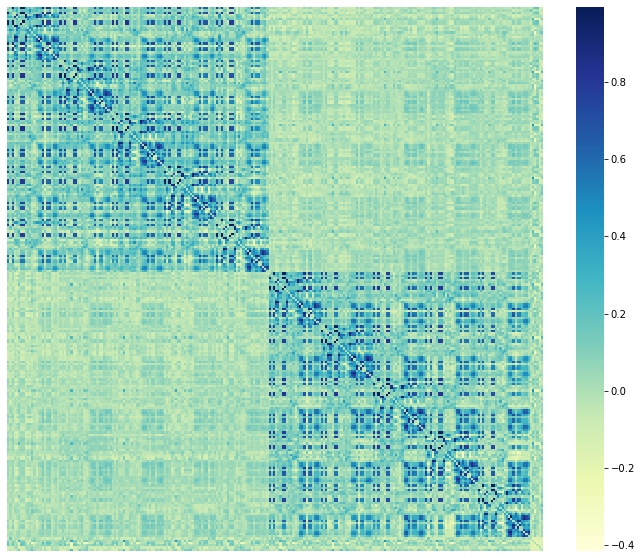

In [29]:
plt.subplots(figsize=(12, 10))
sns.heatmap(X_train_corr, cmap="YlGnBu", annot=False, xticklabels=[], yticklabels=[])
plt.show()

Некоторые признаки очень сильно коррелируют.

In [30]:
corr_trash = 0.99

for idx in X_train_corr.index:
    for col in X_train_corr.columns:
        corr = X_train_corr.loc[idx, col]
        if corr > corr_trash:
            print(f'Пр. 1: {idx :<25} пр. 2: {col :<25} к.к. Пирсона: {corr :.2}')

Пр. 1: team1_p1_total_deaths     пр. 2: team1_p1_rounds_played    к.к. Пирсона: 0.99
Пр. 1: team1_p1_maps_played      пр. 2: team1_p1_rounds_played    к.к. Пирсона: 0.99
Пр. 1: team1_p1_rounds_played    пр. 2: team1_p1_total_deaths     к.к. Пирсона: 0.99
Пр. 1: team1_p1_rounds_played    пр. 2: team1_p1_maps_played      к.к. Пирсона: 0.99
Пр. 1: team1_p2_maps_played      пр. 2: team1_p2_rounds_played    к.к. Пирсона: 0.99
Пр. 1: team1_p2_rounds_played    пр. 2: team1_p2_maps_played      к.к. Пирсона: 0.99
Пр. 1: team1_p3_maps_played      пр. 2: team1_p3_rounds_played    к.к. Пирсона: 0.99
Пр. 1: team1_p3_rounds_played    пр. 2: team1_p3_maps_played      к.к. Пирсона: 0.99
Пр. 1: team1_p4_maps_played      пр. 2: team1_p4_rounds_played    к.к. Пирсона: 0.99
Пр. 1: team1_p4_rounds_played    пр. 2: team1_p4_maps_played      к.к. Пирсона: 0.99
Пр. 1: team1_p5_maps_played      пр. 2: team1_p5_rounds_played    к.к. Пирсона: 0.99
Пр. 1: team1_p5_rounds_played    пр. 2: team1_p5_maps_played     

Некоторые пары признаков имеют линейный коэффициент корреляции близкий к 1. В основном это пары вроде **teamX_pX_maps_played** - **teamX_pX_rounds_played** или **teamX_pX_rounds_played** - **teamX_pX_total_deaths** и т.п. С одной стороны такие признаки можно удалить, т.к. их наличие может усложнить обучение и интерпретацию линейных моделей. С другой стороны первостепенная задача не интерпретируемость модели, а правильное предсказание победителя. К тому же обучение линейных моделей на коррелированных признаках достигается использованием регуляризации, а на качество обучения случайного леса при правильном подборе гиперпараметров мультиколлинеарность практически не влияет.

Пока не будем удалять из модели сильно коррелирующие признаки.

Вычислим корреляцию признаков трейна с целевым признаком. Выведем 3 признака и модулм их коэффициентов корреляции, для которых модули коэффициентов максимальны.

In [31]:
sorted([(col, round(abs(y_train.corr(X_train[col])), 2)) for col in X_train], key=lambda x: x[1], reverse=True)[0:3]

[('team2_p3_kill_death', 0.18),
 ('team2_p3_kill_round', 0.17),
 ('team2_p3_opening_kill_rating', 0.15)]

Неудивительно, что отношение количества убийств к смертям хорошо коррелирует с победой в матче. Но даже максимальная корреляция невелика. По крайней мере по этой причине утечка данных не грозит.

### 2.4 Стандартизация признаков

Для деревянных моделей стандартизация факторов необязательна. Но для регуляризации логистической модели будет полезна.

In [32]:
features_not_ohe = X_train.columns[X_train.columns.str.contains('|'.join(['team1_', 'team2_']))]

scaler = StandardScaler()
scaler.fit(X_train[features_not_ohe])

X_train[features_not_ohe] = scaler.transform(X_train[features_not_ohe])
X_test[features_not_ohe] = scaler.transform(X_test[features_not_ohe])

### 2.5 Заполнение пропусков

Некоторые модели работают с пропусками, некоторые нет. Для капризных моделей заполним пропуски в признаках средними значениями соответствующего признака для ближайших 10 соседей.

In [33]:
X_train_imputed =\
pd.DataFrame(
    KNNImputer(missing_values=np.nan, metric='nan_euclidean', n_neighbors=10).fit_transform(X_train),
    index=X_train.index,
    columns=X_train.columns
)

## 3 Обучение моделей

### 3.1 Scikit Learn LogisticRegression

Обучение модели.

In [34]:
# param_grid = {
#     'solver':       ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
#     'penalty':      ['elasticnet'],
#     'max_iter':     [10000],
#     'l1_ratio':     [None, 0.05, 0.1, 0.15],
#     'C':            [0.1, 0.2, 0.3],
#     'random_state': [12345]
# }
param_grid = {
    'solver':       ['saga'],
    'penalty':      ['elasticnet'],
    'max_iter':     [10000],
    'l1_ratio':     [0.1],
    'C':            [0.2],
    'random_state': [12345]
}
lr = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    refit=True,
    verbose=-1,
    n_jobs=-1
)
_ = lr.fit(X_train_imputed, y_train);
# rfс.cv_results_
print('Лучшее значение AUC-ROC при кросс-валидации:')
print(round(lr.best_score_, 4), '\n')
print('Значения гиперпараметров, при которых оно было достигнуто:')
print(lr.best_params_)

Лучшее значение AUC-ROC при кросс-валидации:
0.6304 

Значения гиперпараметров, при которых оно было достигнуто:
{'C': 0.2, 'l1_ratio': 0.1, 'max_iter': 10000, 'penalty': 'elasticnet', 'random_state': 12345, 'solver': 'saga'}


Три самых больших по модулю коэффициента модели.

In [35]:
sorted(abs(lr.best_estimator_.coef_.flatten()), reverse=True)[:3]

[0.5141176079656479, 0.4750306346418955, 0.45624795566451076]

Значения коэффициентов в норме.

### 3.2 Scikit Learn RandomForest

Обучение модели.

In [36]:
# %%time
# param_grid = {
#     'criterion':         ['gini', 'entropy', 'log_loss'],
#     'min_samples_split': [6, 8, 10],
#     'min_samples_leaf':  [8, 10, 12],
#     'n_estimators':      [100, 125, 150],
#     'max_depth':         [8, 10, 12],
#     'max_features':      ['sqrt', 6, 7, 8],
#     'bootstrap':         [True, False],
#     'random_state':      [12345]
# }
param_grid = {
    'criterion':         ['gini'],  # ['gini', 'entropy', 'log_loss'],
    'min_samples_split': [8],       # [6, 8, 10]
    'min_samples_leaf':  [10],      # [8, 10, 12]
    'n_estimators':      [125],     # [100, 125, 150]
    'max_depth':         [10],      # [8, 10, 12]
    'max_features':      [7],       # ['sqrt', 6, 7, 8]
    'bootstrap':         [True],    # [True, False]
    'random_state':      [12345]    # [12345]
}
rfс = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    refit=True,
    verbose=0,
    n_jobs=-1
)
_ = rfс.fit(X_train_imputed, y_train);
# rfс.cv_results_
print('Лучшее значение AUC-ROC при кросс-валидации:')
print(round(rfс.best_score_, 4), '\n')
print('Значения гиперпараметров, при которых оно было достигнуто:')
print(rfс.best_params_)

Лучшее значение AUC-ROC при кросс-валидации:
0.5966 

Значения гиперпараметров, при которых оно было достигнуто:
{'bootstrap': True, 'criterion': 'gini', 'max_depth': 10, 'max_features': 7, 'min_samples_leaf': 10, 'min_samples_split': 8, 'n_estimators': 125, 'random_state': 12345}


Топ 30 наиболее важных признаков по мнению модели, обученной на тренировочной выборке.

In [37]:
rfс_fi = pd.Series(rfс.best_estimator_.feature_importances_, index=X_train_imputed.columns)
rfс_fi.sort_values(ascending=False, inplace=True)
rfс_fi.head(30)

team2_p3_opening_kill_ratio                   0.009518
team2_p3_kill_round                           0.009389
team2_p3_kill_death_difference                0.009334
team2_p1_team_win_percent_after_first_kill    0.009218
team2_p5_headshots                            0.008812
team1_p3_team_win_percent_after_first_kill    0.008094
team2_p3_headshots                            0.007888
team2_p2_opening_kill_ratio                   0.007882
team1_p2_rounds_played                        0.007583
team1_p5_rounds_played                        0.007557
team2_p1_total_kills                          0.007531
team1_p1_team_win_percent_after_first_kill    0.007481
team1_p4_kill_death                           0.007443
team1_p1_rounds_with_kills                    0.007327
team2_p1_headshots                            0.007278
team1_p3_grenade_damage_per_round             0.007261
team1_p1_kill_death                           0.007070
team2_p2_damage_per_round                     0.006988
team2_p4_k

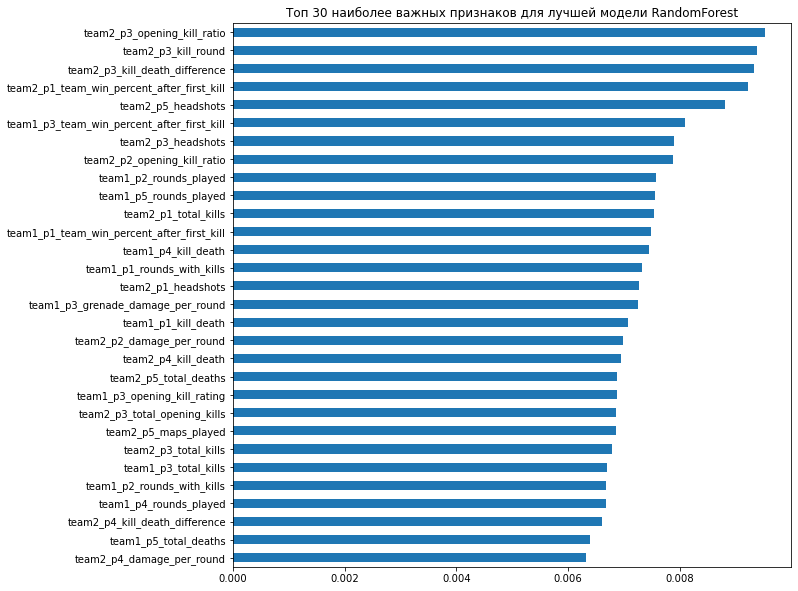

In [38]:
ax = rfс_fi.head(30).plot.barh(figsize=(10, 10), title='Топ 30 наиболее важных признаков для лучшей модели RandomForest');
ax.invert_yaxis()

### 3.3 LGBMClassifier

Обучение модели.

In [39]:
# %%time
# param_grid = {
#     'boosting_type': ['gbdt', 'dart', 'goss'],
#     'num_leaves':    [5, 7, 11, 31],
#     'reg_alpha':     [0, 0.001],
#     'reg_lambda':    [0, 0.1, 0.5],
#     'n_estimators':  [100, 150, 200],
#     'max_depth':     [-1, 20, 50, 75],
#     'random_state':  [12345]
# }
param_grid = {
    'boosting_type': ['dart'],
    'num_leaves':    [11],
    'reg_alpha':     [0.001],
    'reg_lambda':    [0.1],
    'n_estimators':  [100],
    'max_depth':     [-1],
    'random_state':  [12345]
}
lgbmcc = GridSearchCV(
    estimator=LGBMClassifier(),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    refit=True,
    verbose=-1,
    n_jobs=-1
)
_ = lgbmcc.fit(X_train_imputed, y_train);
# lgbmcc.cv_results_
print('Лучшее значение AUC-ROC при кросс-валидации:')
print(round(lgbmcc.best_score_, 4), '\n')
print('Значения гиперпараметров, при которых оно было достигнуто:')
print(lgbmcc.best_params_)

Лучшее значение AUC-ROC при кросс-валидации:
0.5909 

Значения гиперпараметров, при которых оно было достигнуто:
{'boosting_type': 'dart', 'max_depth': -1, 'n_estimators': 100, 'num_leaves': 11, 'random_state': 12345, 'reg_alpha': 0.001, 'reg_lambda': 0.1}


Топ 30 наиболее важных признаков.

In [40]:
lgbmcc_fi = pd.Series(lgbmcc.best_estimator_.feature_importances_, index=X_train_imputed.columns)
lgbmcc_fi.sort_values(ascending=False, inplace=True)
lgbmcc_fi.head(30)

team2_p1_headshots                            30
team2_p3_headshots                            29
team2_p3_opening_kill_ratio                   27
team1_p5_rounds_with_kills                    25
team2_p5_kd_ratio                             20
team1_p3_total_opening_kills                  20
team1_p4_total_kills                          19
team1_p3_headshots                            19
team1_p3_total_kills                          17
team2_p5_rounds_with_kills                    16
team2_p1_team_win_percent_after_first_kill    16
team1_p4_team_win_percent_after_first_kill    16
team2_p2_total_deaths                         15
team2_p2_opening_kill_ratio                   15
team2_p4_kd_ratio                             15
team2_p1_rounds_with_kills                    15
team1_p3_rounds_with_kills                    14
team1_p4_kill_death                           13
team2_p1_total_opening_deaths                 13
team2_p5_headshots                            13
team1_p2_total_openi

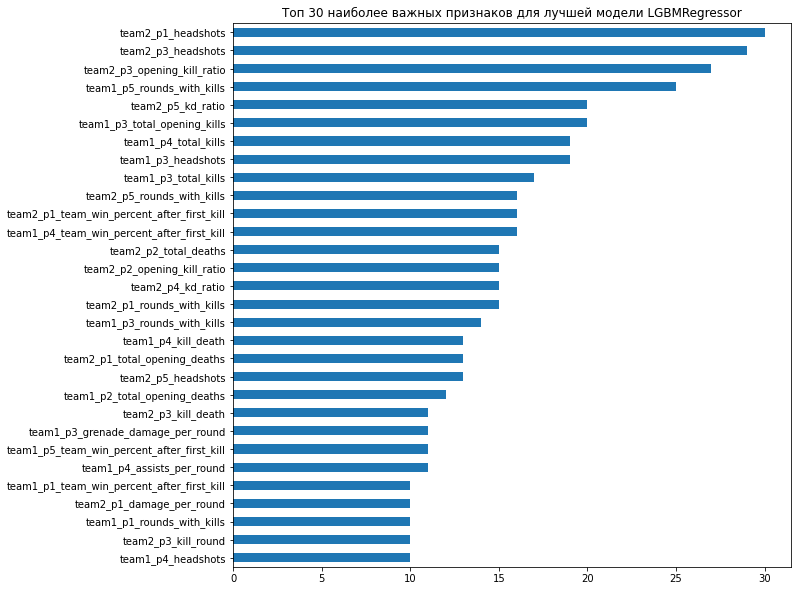

In [41]:
ax = lgbmcc_fi.head(30).plot.barh(figsize=(10, 10), title='Топ 30 наиболее важных признаков для лучшей модели LGBMRegressor');
ax.invert_yaxis() 

### 3.4 CatBoostClassifier

Обучение модели.

In [42]:
# %%time
# param_grid = {
#     'n_estimators':  [80, 110, 120],
#     'max_depth':     [1, 2, 3],
#     'learning_rate': [0.01, 0.1],
#     'verbose':       [False]
# }
param_grid = {
    'n_estimators':  [110],
    'max_depth':     [2],
    'learning_rate': [0.1],
    'verbose':       [False]
}
cbc = GridSearchCV(
    estimator=CatBoostClassifier(),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    refit=True,
    verbose=-1
)
cbc.fit(X_train, y_train)
# cbc.cv_results_;
print('Лучшее значение AUC-ROC при кросс-валидации:')
print(round(cbc.best_score_, 4), '\n')
print('Значения гиперпараметров, при которых оно было достигнуто:')
print(cbc.best_params_)

Лучшее значение AUC-ROC при кросс-валидации:
0.6057 

Значения гиперпараметров, при которых оно было достигнуто:
{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 110, 'verbose': False}


Топ 30 наиболее важных признаков.

In [43]:
cbc_fi = pd.Series(cbc.best_estimator_.feature_importances_, index=X_train.columns)
cbc_fi.sort_values(ascending=False, inplace=True)
cbc_fi.head(30)

team2_p3_headshots                            3.676222
team2_p3_opening_kill_ratio                   3.466083
team2_p1_headshots                            3.259592
team1_p2_total_opening_deaths                 2.723651
team2_p5_kd_ratio                             2.573133
team1_p3_team_win_percent_after_first_kill    2.528288
team2_p3_opening_kill_rating                  2.098562
team2_p5_headshots                            2.080365
team2_p3_first_kill_in_won_rounds             1.922054
team2_p1_rounds_with_kills                    1.858031
team2_p3_kill_death                           1.759324
team2_p5_total_opening_deaths                 1.722735
team2_p4_damage_per_round                     1.684231
team1_p3_opening_kill_rating                  1.645516
team2_p4_kd_ratio                             1.614708
team2_p2_opening_kill_ratio                   1.574161
team1_p1_total_opening_deaths                 1.569567
team2_p1_total_opening_kills                  1.505560
team1_p3_t

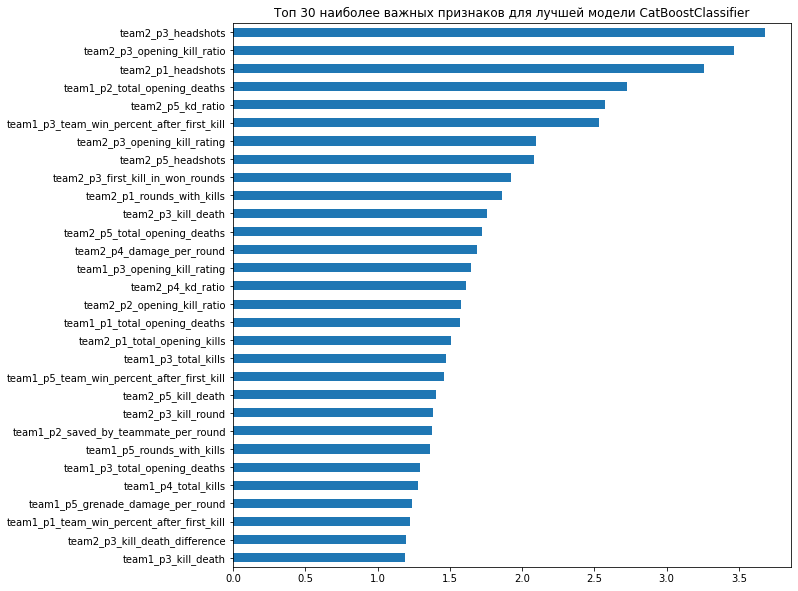

In [44]:
ax = cbc_fi.head(30).plot.barh(figsize=(10, 10), title='Топ 30 наиболее важных признаков для лучшей модели CatBoostClassifier');
ax.invert_yaxis()

### 3.5 Примитивный классификатор DummyClassifier

За неимением таргета для теста, опробуем тупой классификатор на кросс-валидации. Ставлю на 0.5!

In [45]:
dc = GridSearchCV(
    estimator=DummyClassifier(strategy='most_frequent'),
    param_grid={},
    scoring='roc_auc',
    cv=5,
    refit=True,
    verbose=-1
)
dc.fit(X_train_imputed, y_train)
print('Лучшее значение AUC-ROC при кросс-валидации:')
print(round(dc.best_score_, 4), '\n')

Лучшее значение AUC-ROC при кросс-валидации:
0.5 



## 4 Предсказание

Предскажем исходы матчей с помощью трех обученных моделей, показавших на кросс-валидации наибольшие значения метрики AUC-ROC.

Прогноз модели LogisticRegression.

In [46]:
y_test_pred_log_reg = lr.best_estimator_.predict(X_test)
y_test_pred_log_reg

array([1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 1, 1, 1, 1])

In [47]:
with open('./prediction_1.txt', 'a') as f:
    f.write(' '.join(map(str, y_test_pred_log_reg)))

Модели CatBoostClassifier.

In [48]:
y_test_pred_cat_boost = cbc.best_estimator_.predict(X_test)
y_test_pred_cat_boost

array([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 1])

In [49]:
with open('./prediction_2.txt', 'a') as f:
    f.write(' '.join(map(str, y_test_pred_cat_boost)))

И модели RandomForestClassifier.

In [50]:
y_test_pred_rand_forest = cbc.best_estimator_.predict(X_test)
y_test_pred_rand_forest

array([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 1])

In [51]:
with open('./prediction_3.txt', 'a') as f:
    f.write(' '.join(map(str, y_test_pred_rand_forest)))

## 5 Вывод

А вывод делать пока рано. ))